<a href="https://colab.research.google.com/github/Danysan1/ai-unibo-nlp-project/blob/main/a1/execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assigment 1 execution

Team members: Daniel Bernardi, Daniele Santini, Hiari Pizzini Cavagna and Muhammad Saleem Ghulam.

Corpora: https://www.nltk.org/nltk_data/ , point 91, "Dependency Parsed Treebank" ([link](https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip)).

Docs:
* https://www.nltk.org/api/nltk.corpus.html
* https://www.nltk.org/data.html
* https://www.nltk.org/install.html

## Preparing the environment

In [1]:
%pip install pandas numpy matplotlib gensim==4.2.0 tensorflow-addons keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.1 MB/s eta 0:00:00
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [2]:
import os, shutil  #  file management
import sys 
import pandas as pd  #  dataframe management
import numpy as np  #  data manipulation
import re
import urllib.request  # download files
from zipfile import ZipFile # extract files
from matplotlib import pyplot as plt
import tensorflow_addons as tfa
from sklearn.metrics import f1_score
import keras
import keras_tuner

In [3]:
if not os.path.exists("./report"):
    os.makedirs("./report")

## Downloading the dataset

In [4]:
dataset_folder = os.path.join(os.getcwd(), "Dataset")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'

dataset_path = os.path.join(dataset_folder, "dependency_treebank.zip")

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, dataset_path)
    print("Successful download")
    
with ZipFile(dataset_path, 'r') as zObject:
  # Extracting all the members of the zip  into a specific location.
  zObject.extractall(dataset_folder)
  print("Successful extraction")

Successful download
Successful extraction


## Loading the data

In [5]:
def loadCorpus(start:int, stop:int=None):
    '''
    Loads the data for the specified file range.
    
    Removes the third column 'num', which is not necessary for this task.

    Parameters:
        start: start of numeric range of files (inclusive)
        stop: end of numeric range of files (exclusive)
    '''
    dataset_name = "dependency_treebank"
    folder = os.path.join(os.getcwd(), "Dataset", dataset_name)

    if stop==None:
        stop = start+1
    
    return pd.concat([
        pd.read_csv(
            f'{folder}/wsj_{"{:04d}".format(num)}.dp',
            sep="\t",
            usecols=[0,1],
            names=["word","label"]
        ) for num in range(start, stop)
    ])

In [6]:
full_dataset = loadCorpus(1,200)

## Exploratory Data Analysis

In [7]:
full_dataset.count()

word     94084
label    94084
dtype: int64

In [8]:
full_dataset.head(20)

,word,label
0,Pierre,NNP
1,Vinken,NNP
2,",",","
3,61,CD
4,years,NNS
5,old,JJ
6,",",","
7,will,MD
8,join,VB
9,the,DT


Each document contains a different tokenized article:

In [9]:
sample_article = loadCorpus(1)
" ".join(sample_article["word"])

'Pierre Vinken , 61 years old , will join the board as a nonexecutive director Nov. 29 . Mr. Vinken is chairman of Elsevier N.V. , the Dutch publishing group .'

In [10]:
" ".join(loadCorpus(2)["word"])

'Rudolph Agnew , 55 years old and former chairman of Consolidated Gold Fields PLC , was named a nonexecutive director of this British industrial conglomerate .'

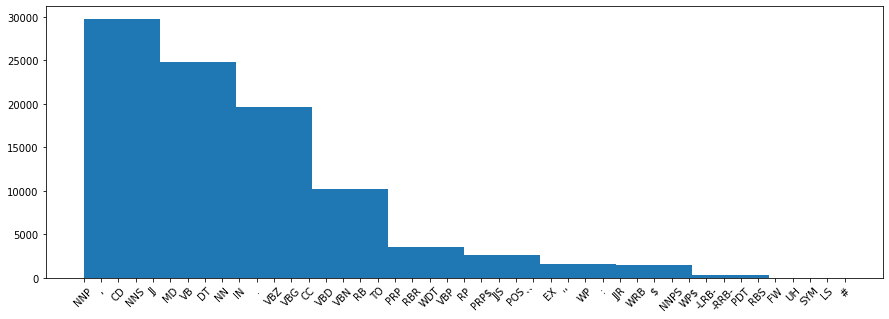

In [11]:
fig=plt.figure(figsize=(15,5))
p = plt.hist(full_dataset["label"])
plt.xticks(rotation=45)
fig.savefig('./report/classes_with_punctuation.png')
fig.show()

A full list of classes can be found at https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

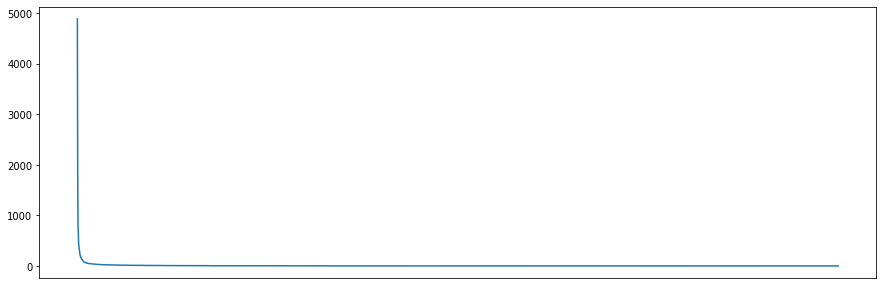

In [12]:
fig=plt.figure(figsize=(15,5))
p = plt.plot(full_dataset["word"].value_counts())
plt.xticks([])
plt.show()

## Data splitting





Creation of train, validation and test sets.

In [13]:
df_train = loadCorpus(1,101) 
df_val = loadCorpus(101,151)
df_test = loadCorpus(151,200)

df_train.count()

word     47356
label    47356
dtype: int64

In [14]:
df_val.count()

word     31183
label    31183
dtype: int64

In [15]:
df_test.count()

word     15545
label    15545
dtype: int64

## Data pre-processing

Clean the data.

In [16]:
def cleanCorpus(corpus):
    # Lower every word    
    corpus['word'] = corpus['word'].str.lower()
    return corpus

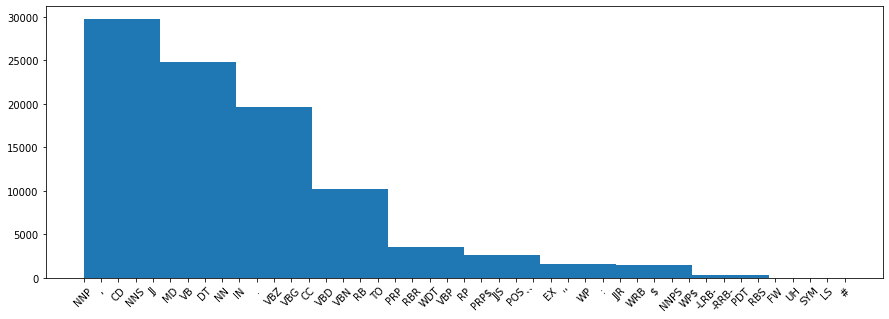

In [17]:
fig=plt.figure(figsize=(15,5))
p = plt.hist(cleanCorpus(full_dataset)["label"])
plt.xticks(rotation=45)
plt.show()

In [18]:
#cleaned dataframes
dfc_train = cleanCorpus(df_train)
dfc_val = cleanCorpus(df_val)
dfc_test = cleanCorpus(df_test)
dfc_sample = cleanCorpus(sample_article)

dfc_train.count()

word     47356
label    47356
dtype: int64

In [19]:
dfc_val.count()

word     31183
label    31183
dtype: int64

In [20]:
dfc_test.count()

word     15545
label    15545
dtype: int64

In [21]:
dfc_train.head(20)

,word,label
0,pierre,NNP
1,vinken,NNP
2,",",","
3,61,CD
4,years,NNS
5,old,JJ
6,",",","
7,will,MD
8,join,VB
9,the,DT


## Word embedding

### Loading GloVe


Loading pre-trained dense word embedding representation: GloVe.






In [22]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(model_type: str,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = ""
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")
        
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        print('FastText: 300')
        raise e

    return emb_model

In [23]:
# Glove -> 50, 100, 200, 300 (200 seems the better)
embedding_dimension = 200
embedding_model = load_embedding_model(model_type="glove", embedding_dimension= embedding_dimension)

[==================================================] 100.0% 252.1/252.1MB downloaded


### Analyzing OOV statistics

In [24]:
embedding_model.index_to_key[0:10]

['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s"]

In [25]:
oov_train = list(set([word for word in dfc_train.word.values if word not in embedding_model.index_to_key]))
oov_val = list(set([word for word in dfc_val.word.values if word not in embedding_model.index_to_key]))
oov_test = list(set([word for word in dfc_test.word.values if word not in embedding_model.index_to_key]))
print(f'oov_train_size: {len(oov_train)}')
print(f'oov_val_size: {len(oov_val)}')
print(f'oov_test_size: {len(oov_test)}')

oov_train_size: 359
oov_val_size: 213
oov_test_size: 161


In [26]:
oov_train[0:10]

['jalaalwalikraam',
 'bellringers',
 'rate-sensitive',
 'greenmailer',
 'chemplus',
 'rubinfien',
 'pre-1917',
 '143.80',
 'video-viewing',
 'trettien']

### GloVe Embedding

#### Prepare the embedding matrix

In [27]:
def handle_OOV(vectors, vocabulary, embedding_dimension, oov_set):
  #deal with oov words by adding a random embedding vector to the embedding matrix
  for idx in range(0, len(oov_set)):
    if oov_set[idx] not in vocabulary:
      vocabulary.append(oov_set[idx])
      #use random embedding for OOV word
      embedding_vector = np.random.uniform(low=-0.05, high=0.05, size= embedding_dimension)
      vectors.append(embedding_vector)
  return vocabulary, vectors

In [28]:
#GloVe vocabulary
words = list(embedding_model.index_to_key)
#extracting the GloVe embedding vectors
vectors = [embedding_model[word] for word in words]
#add an embbedding vector of zeros at the index 0
em0 =np.array([0.0]*embedding_dimension)
vectors.insert(0, em0)

#handle with train oov words
vocab, vectors = handle_OOV(vectors, words, embedding_dimension, oov_train)
#handle with validation oov words
vocab, vectors = handle_OOV(vectors, vocab, embedding_dimension, oov_val)
#handle with test oov words
vocab, vectors = handle_OOV(vectors, vocab, embedding_dimension, oov_test)

embedding_matrix = np.asarray(vectors)
print(f'Embedding matrix shape: {np.shape(embedding_matrix)}')


Embedding matrix shape: (400677, 200)


Define the tokenizer.

In [29]:
from tensorflow.keras.preprocessing.text import Tokenizer

# define the tokenizer, removing the default filters: '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' 
tokenizer = Tokenizer(filters='')
#fit the tokenizer on the vocabulary of GloVe, including also the OOV words 
tokenizer.fit_on_texts(vocab)

# number of unique words in dict.
print("Number of unique words in dictionary=", len(tokenizer.word_index))
print("Dictionary head: ", dict(list(tokenizer.word_index.items())[0:50]))

Number of unique words in dictionary= 400676
Dictionary head:  {'the': 1, ',': 2, '.': 3, 'of': 4, 'to': 5, 'and': 6, 'in': 7, 'a': 8, '"': 9, "'s": 10, 'for': 11, '-': 12, 'that': 13, 'on': 14, 'is': 15, 'was': 16, 'said': 17, 'with': 18, 'he': 19, 'as': 20, 'it': 21, 'by': 22, 'at': 23, '(': 24, ')': 25, 'from': 26, 'his': 27, "''": 28, '``': 29, 'an': 30, 'be': 31, 'has': 32, 'are': 33, 'have': 34, 'but': 35, 'were': 36, 'not': 37, 'this': 38, 'who': 39, 'they': 40, 'had': 41, 'i': 42, 'which': 43, 'will': 44, 'their': 45, ':': 46, 'or': 47, 'its': 48, 'one': 49, 'after': 50}


In [30]:
with open('./Dataset/word_index.json','w') as word_index_file:
    word_index_file.write(tokenizer.to_json())

#### Encode the dataset

Here we define a label encoder for the target class.

In [31]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le = LabelEncoder()
dfc_train['encoded_label'] = le.fit_transform(dfc_train['label'])
dfc_val['encoded_label'] = le.transform(dfc_val['label'])
dfc_test['encoded_label'] = le.transform(dfc_test['label'])
dfc_sample['encoded_label'] = le.transform(dfc_sample['label'])

In [32]:
df_labels = pd.concat([dfc_train, dfc_val, dfc_test]).drop("word", axis=1)
df_labels = df_labels.drop_duplicates()
df_labels = df_labels.reset_index(drop=True)
df_labels.head()

,label,encoded_label
0,NNP,20
1,",",3
2,CD,9
3,NNS,22
4,JJ,14


In [33]:
dfc_train.head(20)

,word,label,encoded_label
0,pierre,NNP,20
1,vinken,NNP,20
2,",",",",3
3,61,CD,9
4,years,NNS,22
5,old,JJ,14
6,",",",",3
7,will,MD,18
8,join,VB,34
9,the,DT,10


In [34]:
# Filter out punctuation based on the class
# https://universaldependencies.org/docs/en/pos/all.html#al-en-pos/PUNCT
punctuation_classes = [ 
    "``", "’’", "-LRB-", "-RRB-", ",", ".", ":", "HYPH", # PUNCT: punctuation
    "#", "$", "SYM", # SYM: symbol
    "''", # Custom
]

# Select all the unique classes in the dataframe and their encoding
labels = dfc_train.drop_duplicates(['label','encoded_label'])[['label','encoded_label']]

# Extracting the encoded label vector for all punctuation and symbols. Will be used in F1 score calculation   
punctuation_labels = labels[labels.label.isin(punctuation_classes)]['encoded_label'].values

print(f"Punctation labels: {punctuation_labels}")

Punctation labels: [ 3  6 44  2  7  1  4  5 31  0]


Transform the text into a sequence of integers using the tokenizer defined before. 

In [35]:
x_train = np.array(tokenizer.texts_to_sequences(dfc_train.word.values)) 
y_train = np.array( dfc_train['encoded_label'])

x_val = np.array(tokenizer.texts_to_sequences(dfc_val.word.values))
y_val = np.array(dfc_val['encoded_label'])

x_test = np.array(tokenizer.texts_to_sequences(dfc_test.word.values))
y_test = np.array(dfc_test['encoded_label'])

x_sample = np.array(tokenizer.texts_to_sequences(dfc_sample.word.values))
y_sample = np.array(dfc_sample['encoded_label'])

#number of unique labels
num_classes = len(np.unique(y_train))
print(f'The number of unique classes in the training data: {num_classes}')

The number of unique classes in the training data: 45


Padding the sequences to make them of the same length before passing them to the model, of course in this case is not a necessary operation because we are processing single words, but in other case it's a crucial operation.

In [36]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Padding 
max = 1
x_train = pad_sequences(x_train, maxlen=max, padding='post')
x_val = pad_sequences(x_val, maxlen=max, padding='post')
x_test = pad_sequences(x_test, maxlen=max, padding='post')
x_sample = pad_sequences(x_sample, maxlen=max, padding='post')

#Training shape
print(f'X train shape: {x_train.shape}')
print(f'Y train shape: {y_train.shape}')

# Validation shape
print(f'X val shape: {x_val.shape}')
print(f'Y val shape: {y_val.shape}')

# Test shape
print(f'X test shape: {x_test.shape}')
print(f'Y test shape: {y_test.shape}')

X train shape: (47356, 1)
Y train shape: (47356,)
X val shape: (31183, 1)
Y val shape: (31183,)
X test shape: (15545, 1)
Y test shape: (15545,)


In [37]:
vocab_size = len(tokenizer.word_index) + 1

## Utility methods

In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from typing import List, Dict, Callable
import random

In [102]:
def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    tf.config.experimental.enable_op_determinism()
    tf.keras.utils.set_random_seed(seed)


# Set the reproducibility
set_reproducibility(42)

In [40]:
import matplotlib.pyplot as plt
from functools import partial
from keras.callbacks import History

def show_history(history: History):
    """
    Shows training history data stored by the History Keras callback

    :param history: History Keras callback
    """
    history_data = history.history
    print(f"Displaying the following history keys: {history_data.keys()}")
    
    for key, value in history_data.items():
        if not key.startswith('val'):
            fig, ax = plt.subplots(1, 1)
            ax.set_title(key)
            ax.plot(value)
            if f'val_{key}' in history_data:
                ax.plot(history_data[f'val_{key}'])
            else:
                print(f"Couldn't find validation values for metric: {key}")

            ax.set_ylabel(key)
            ax.set_xlabel('epoch')
            ax.legend(['train', 'val'], loc='best')
            plt.grid(True)
        plt.show()

In [41]:
def train_model(model: keras.Model, training_info: Dict):
    """
    Training routine for the Keras model.
    At the end of the training, retrieved History data is shown.

    :param model: Keras built model
    :param training_info: dictionary storing model fit() argument information

    :return
        model: trained Keras model
    """

    print(f"Start training! \nParameters: {training_info}")

    history = model.fit(x=x_train, y=y_train,
                        validation_data=(x_val, y_val),
                        **training_info)
    print("Training completed!")

    print("Showing history...")
    show_history(history)

    return model

In [42]:
def predict_data(model: keras.Model,
                x: np.ndarray,
                prediction_info: Dict):
    """
    Inference routine of a given input set of examples

    :param model: Keras built and possibly trained model
    :param x: input set of examples in np.ndarray format
    :param prediction_info: dictionary storing model predict() argument information

    :return
        predictions: predicted labels in np.ndarray format
    """
    print(f'Starting prediction: \n{prediction_info}')
    print(f'Predicting on {x.shape[0]} samples')
    predictions = model.predict(x, **prediction_info)
    return predictions

In [43]:
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay

def compute_f1(model: keras.Model, 
             x: np.ndarray, 
             y: np.ndarray,
             get_report: bool = False):
    """
    Compute F1_score on the given data with corresponding labels

    :param model: Keras built and possibly trained model
    :param x: data in np.ndarray format
    :param y: ground-truth labels in np.ndarray format

    :return
        score: f1_macro_score
    """
    prediction_info = {
        'batch_size': 64,
        'verbose': 1
    }
    
    #predictions on the x set
    y_pred = predict_data(model=model, x=x, prediction_info=prediction_info)

    #compute argmax to take the best class for each sample
    y_pred = np.argmax(y_pred, axis=1)
    
    #compute the f1_macro excluding punctuaction labels
    labels = np.unique( np.concatenate((np.unique(y), np.unique(y_pred))))
    labels = [label for label in labels if label not in punctuation_labels]
    
    rep = classification_report(y,y_pred, labels=labels, output_dict=True, zero_division=0)

    # Show confusion matrix
    '''
    cm = confusion_matrix(y,y_pred,labels=labels)
    cm_disp = ConfusionMatrixDisplay(cm,display_labels=labels)
    fig, ax = plt.subplots(figsize=(15,15))
    cm_disp.plot(ax=ax)
    '''
    score = f1_score(y, y_pred, average ='macro', labels=labels)

    if get_report:
        return score, rep
    else: return score

## Baseline model: LSTM

### Define the model

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam


def create_baseline(units, dropout, learning_rate, activation):
    model = keras.Sequential()
    model = keras.models.Sequential()
    
    
    model.add(keras.layers.Embedding(input_dim=vocab_size, 
                                    output_dim = embedding_dimension,
                                    input_length = 1,
                                    weights = [embedding_matrix],
                                    trainable = False))
    
    model.add(keras.layers.Bidirectional(LSTM(units=units, 
                                              activation=activation,
                                              dropout=dropout,
                                              )))

    model.add(keras.layers.Dense(units=num_classes, 
                                 activation="softmax"))

    model.summary()

    model.compile(loss='sparse_categorical_crossentropy', 
                    optimizer=Adam(learning_rate=learning_rate), 
                    metrics=["accuracy"])
    
    return model

#### Using keras tuner to find best hyper parameters

In [81]:
import keras_tuner

def build_baseline(hp):
    units = hp.Int("units", min_value=16, max_value=128, step=16)

    activation = hp.Choice("activation", ["relu", "tanh"])

    dropout = hp.Float("dropout", min_value=0, max_value=0.2, step=0.05)

    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = create_baseline(units=units, 
                            activation=activation, 
                            dropout=dropout, 
                            learning_rate=learning_rate
                        )
    return model

In [ ]:
if not os.path.exists("./models"):
    os.makedirs("./models")

tuner = keras_tuner.Hyperband(hypermodel=build_baseline,
                            objective='accuracy',
                            max_epochs=30,
                            factor=3,
                            directory='./models',
                            project_name='baseline')
tuner.search_space_summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 200)            80135400  
                                                                 
 bidirectional (Bidirectiona  (None, 32)               27776     
 l)                                                              
                                                                 
 dense (Dense)               (None, 45)                1485      
                                                                 
Total params: 80,164,661
Trainable params: 29,261
Non-trainable params: 80,135,400
_________________________________________________________________
Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['re

In [ ]:
# Search the best hyper-parameter and select the best model
'''
tuner.search(x_train,y_train, epochs=30, validation_data=(x_val,y_val))
best_model = tuner.get_best_models()[0]
tuner.results_summary()
'''

'\ntuner.search(x_train,y_train, epochs=30, validation_data=(x_val,y_val))\nbest_model = tuner.get_best_models()[0]\ntuner.results_summary()\n'

Hyperparameters:
* units: 32
* activation: tanh
* dropout: 0
* learning_rate: 0.0028081
* tuner/epochs: 30
* tuner/initial_epoch: 10

Score: 0.9271686673164368

In [106]:
# Create model with best hyperparameter 
base_model = create_baseline(units= 32,
                            activation="tanh",
                            dropout=0,
                            #learning_rate=28e-4)
                            learning_rate=0.0028081)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 1, 200)            80135400  
                                                                 
 bidirectional_12 (Bidirecti  (None, 64)               59648     
 onal)                                                           
                                                                 
 dense_13 (Dense)            (None, 45)                2925      
                                                                 
Total params: 80,197,973
Trainable params: 62,573
Non-trainable params: 80,135,400
_________________________________________________________________


Start training! 
Parameters: {'verbose': 0, 'epochs': 6, 'batch_size': 64}
Training completed!
Showing history...
Displaying the following history keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


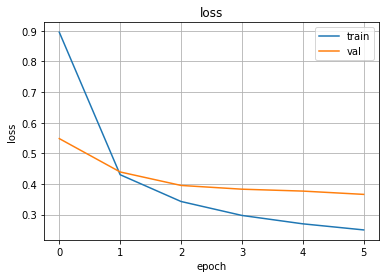

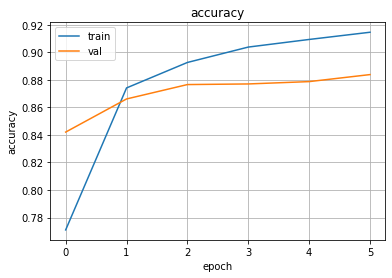

In [107]:
# Train
base_training_info = {
    'verbose': 0,
    'epochs' : 6,
    'batch_size' : 64,
    
}

'''
    'callbacks' : [tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                    patience=5,
                                                    verbose=1,
                                                    mode="auto",
                                                    baseline=None,
                                                    restore_best_weights=True)]
'''

base_model = train_model(model=base_model,training_info = base_training_info)

#### F1-Macro evaluation

In [108]:
loss, accuracy = base_model.evaluate(x_val, y_val)
print(f"Model loss: {loss}, accuracy: {accuracy}")

# Inference and evaluate

base_score = compute_f1(base_model, x_val, y_val)
print(f'F1_score on the validation set is: {base_score}')

975/975 [==============================] - 3s 3ms/step - loss: 0.3660 - accuracy: 0.8838
Model loss: 0.3659779727458954, accuracy: 0.8838148713111877
Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 31183 samples
488/488 [==============================] - 2s 2ms/step
F1_score on the validation set is: 0.7158898975529938


#### Sample test

In [109]:
x_sample_text = tokenizer.sequences_to_texts(x_sample)
y_pred_sample_onehot = base_model.predict(x_sample)
y_pred_sample = np.argmax(y_pred_sample_onehot, axis=1)
for i in range(x_sample.size):
    print(f"{y_pred_sample[i]} \t {y_sample[i]} \t {'ok' if y_pred_sample[i]==y_sample[i] else 'ERR'} \t {x_sample_text[i]}")

1/1 [==============================] - 0s 23ms/step
20 	 20 	 ok 	 pierre
20 	 20 	 ok 	 vinken
3 	 3 	 ok 	 ,
9 	 9 	 ok 	 61
22 	 22 	 ok 	 years
14 	 14 	 ok 	 old
3 	 3 	 ok 	 ,
18 	 18 	 ok 	 will
34 	 34 	 ok 	 join
10 	 10 	 ok 	 the
19 	 19 	 ok 	 board
13 	 13 	 ok 	 as
10 	 10 	 ok 	 a
14 	 14 	 ok 	 nonexecutive
19 	 19 	 ok 	 director
20 	 20 	 ok 	 nov.
9 	 9 	 ok 	 29
6 	 6 	 ok 	 .
20 	 20 	 ok 	 mr.
20 	 20 	 ok 	 vinken
39 	 39 	 ok 	 is
19 	 19 	 ok 	 chairman
13 	 13 	 ok 	 of
20 	 20 	 ok 	 elsevier
20 	 20 	 ok 	 n.v.
3 	 3 	 ok 	 ,
10 	 10 	 ok 	 the
14 	 20 	 ERR 	 dutch
20 	 36 	 ERR 	 publishing
20 	 19 	 ERR 	 group
6 	 6 	 ok 	 .


## Model A: GRU

GRU is a simpler alternative to LSTM's architecture, less effective but with a faster train.
</br>Two layers architecture: a Bidirectional GRU layer and a Dense/FC layer on top. 

In [110]:
# Create model

def create_gru(units, dropout, learning_rate, activation):
    model = keras.Sequential()
    model = keras.models.Sequential()
    
    
    model.add(keras.layers.Embedding(input_dim=vocab_size, 
                                    output_dim = embedding_dimension,
                                    input_length = 1,
                                    weights = [embedding_matrix],
                                    trainable = False))
    
    model.add(keras.layers.Bidirectional(GRU(units=units, 
                                              activation=activation,
                                              dropout=dropout,
                                              )))

    model.add(keras.layers.Dense(units=num_classes, 
                                 activation="softmax"))

    model.compile(loss="sparse_categorical_crossentropy", 
                    optimizer=Adam(learning_rate=learning_rate), 
                    metrics=["accuracy"])
    
    return model

In [111]:
def build_GRU(hp):
    units = hp.Int("units", min_value=16, max_value=256, step=16)

    activation = hp.Choice("activation", ["relu", "tanh"])

    dropout = hp.Float("dropout", min_value=0, max_value=0.2, step=0.05)

    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = create_gru(units=units, 
                            activation=activation, 
                            dropout=dropout, 
                            learning_rate=learning_rate
                        )
    return model

In [112]:
tuner = keras_tuner.Hyperband(hypermodel=build_GRU,
                            objective='accuracy',
                            max_epochs=30,
                            factor=3,
                            directory='a1models',
                            project_name='GRU')
tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.2, 'step': 0.05, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [113]:
# Search the best hyper-parameter and select the best model
'''
tuner.search(x_train,y_train, epochs=30, validation_data=(x_val,y_val))
best_model = tuner.get_best_models()[0]
tuner.results_summary()
'''

'\ntuner.search(x_train,y_train, epochs=30, validation_data=(x_val,y_val))\nbest_model = tuner.get_best_models()[0]\ntuner.results_summary()\n'

Hyperparameters:
* units: 112
* activation: tanh
* dropout: 0.05
* learning_rate: 0.000642144054857491
* tuner/epochs: 15
  
Score: 0.9216994643211365

In [114]:
# Create model with best hyperparameter 
gru_model = create_gru(units= 112,
                            activation="tanh",
                            dropout=0.05,
                            learning_rate=0.000642144054857491,
                            )

Start training! 
Parameters: {'verbose': 0, 'epochs': 17, 'batch_size': 64}
Training completed!
Showing history...
Displaying the following history keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


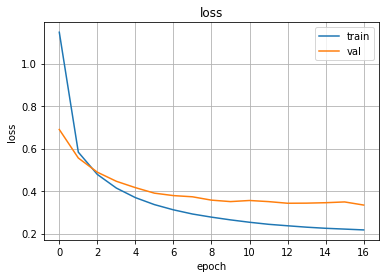

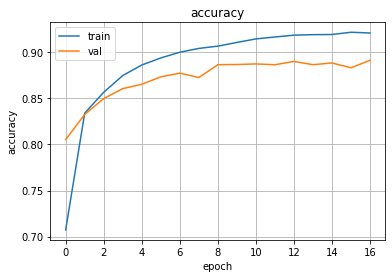

In [115]:
# Train
gru_training_info = {
    'verbose': 0,
    'epochs' : 17,
    'batch_size' : 64,

}

gru_model = train_model(model=gru_model,training_info = gru_training_info)

#### F1-Macro evaluation

In [116]:
loss, accuracy = gru_model.evaluate(x_val, y_val)
print(f"Model loss: {loss}, accuracy: {accuracy}")

# Inference and evaluate

gru_score = compute_f1(gru_model, x_val, y_val)
print(f'F1_score on the validation set is: {gru_score}')

975/975 [==============================] - 3s 3ms/step - loss: 0.3342 - accuracy: 0.8914
Model loss: 0.33421263098716736, accuracy: 0.8913831114768982
Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 31183 samples
488/488 [==============================] - 2s 2ms/step
F1_score on the validation set is: 0.7014973750824088


## Model B: 2x LSTM + Dense 

In [117]:
# Create model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam

def create_2xlstm(lstm1_units, lstm2_units, lstm1_dropout, lstm2_dropout, learning_rate, lstm1_activation, lstm2_activation):
    model = keras.Sequential()
    model = keras.models.Sequential()
    
    
    model.add(keras.layers.Embedding(input_dim=vocab_size, 
                                    output_dim = embedding_dimension,
                                    input_length = 1,
                                    weights = [embedding_matrix],
                                    trainable = False))
    
    model.add(keras.layers.Bidirectional(LSTM(units=lstm1_units,
                                              dropout=lstm1_dropout,
                                              activation=lstm1_activation,
                                              return_sequences=True
                                              )))
    
    model.add(keras.layers.Bidirectional(LSTM(units=lstm2_units,
                                              dropout=lstm2_dropout,
                                              activation=lstm2_activation
                                              )))

    model.add(keras.layers.Dense(units=num_classes, 
                                 activation="softmax"))

    model.compile(loss="sparse_categorical_crossentropy", 
                    optimizer=Adam(learning_rate=learning_rate), 
                    metrics=["accuracy"])
    
    return model

In [118]:
def build_2xLSTM(hp):
    lstm1_units = hp.Int("lstm1_units", min_value=16, max_value=128, step=16)
    lstm2_units = hp.Int("lstm2_units", min_value=16, max_value=128, step=16)

    lstm1_activation = hp.Choice("lstm1_activation", ["relu", "tanh"])
    lstm2_activation = hp.Choice("lstm2_activation", ["relu", "tanh"])

    lstm1_dropout = hp.Float("lstm1_dropout", min_value=0, max_value=0.4, step=0.1)
    lstm2_dropout = hp.Float("lstm2_dropout", min_value=0, max_value=0.4, step=0.1)

    learning_rate = hp.Float("learning_rate", min_value=1e-3, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = create_2xlstm(lstm1_units=lstm1_units,
                            lstm2_units=lstm2_units, 
                            lstm1_activation=lstm1_activation, 
                            lstm2_activation=lstm2_activation,
                            lstm1_dropout=lstm1_dropout,
                            lstm2_dropout=lstm2_dropout,
                            learning_rate=learning_rate
                        )
    return model

In [119]:
tuner = keras_tuner.Hyperband(hypermodel=build_2xLSTM,
                            objective='accuracy',
                            max_epochs=30,
                            factor=3,
                            directory='models',
                            project_name='2xLSTM')
tuner.search_space_summary()

Search space summary
Default search space size: 7
lstm1_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
lstm2_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
lstm1_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
lstm2_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
lstm1_dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.1, 'sampling': None}
lstm2_dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [120]:
# Search the best hyper-parameter and select the best model
"""
tuner.search(x_train,y_train, epochs=30, validation_data=(x_val,y_val),
                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                                        min_delta=0.015,
                                                                        patience=3,
                                                                        verbose=0,
                                                                        mode="auto",
                                                                        baseline=None,
                                                                        restore_best_weights=True)])
best_model = tuner.get_best_models()[0]
tuner.results_summary()
"""

'\ntuner.search(x_train,y_train, epochs=30, validation_data=(x_val,y_val),\n                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",\n                                                                        min_delta=0.015,\n                                                                        patience=3,\n                                                                        verbose=0,\n                                                                        mode="auto",\n                                                                        baseline=None,\n                                                                        restore_best_weights=True)])\nbest_model = tuner.get_best_models()[0]\ntuner.results_summary()\n'

Hyperparameters:
* LSTM1_units: 128
* LSTM2_units: 112
* LSTM1_activation: tanh
* LSTM2_activation: relu
* LSTM1_dropout: 0.0
* LSTM2_dropout: 0.2
* learning_rate: 0.0014114864841283698
* tuner/epochs: 10
  
Score: 0.9165892601013184

In [121]:
# Create model with best hyperparameter 
LSTMx2_model = create_2xlstm(lstm1_units=128,
                                    lstm2_units=112,
                                    lstm1_activation="tanh",
                                    lstm2_activation="relu",
                                    lstm1_dropout=0.2,
                                    lstm2_dropout=0.0,
                                    learning_rate=0.0014114864841283698) 

Start training! 
Parameters: {'verbose': 0, 'epochs': 7, 'batch_size': 64}
Training completed!
Showing history...
Displaying the following history keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


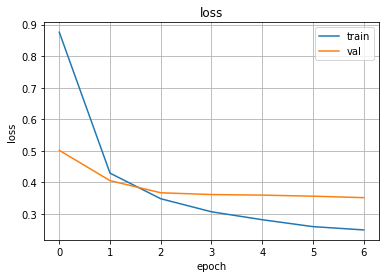

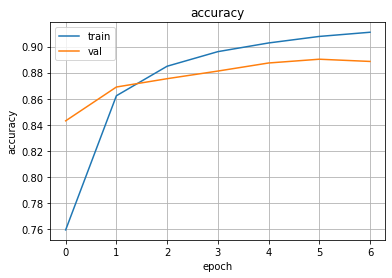

In [122]:
# Train
LSTMx2_training_info = {
    'verbose': 0,
    'epochs' : 7,
    'batch_size' : 64,
    
}

LSTMx2_model = train_model(model=LSTMx2_model,training_info = LSTMx2_training_info)

#### F1-Macro evaluation

In [123]:
loss, accuracy = LSTMx2_model.evaluate(x_val, y_val)
print(f"Model loss: {loss}, accuracy: {accuracy}")

# Inference and evaluate

LSTMx2_score = compute_f1(LSTMx2_model, x_val, y_val)
print(f'F1_score on the validation set is: {LSTMx2_score}')

975/975 [==============================] - 4s 4ms/step - loss: 0.3518 - accuracy: 0.8886
Model loss: 0.3518246114253998, accuracy: 0.8885610699653625
Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 31183 samples
488/488 [==============================] - 2s 3ms/step
F1_score on the validation set is: 0.7073631759712223


## Model C: LSTM + 2x Dense

In [124]:
# Create model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam

def create_lstm_dense(lstm_units, dense_units, lstm_dropout, learning_rate, lstm_activation, dense_activation):
    model = keras.Sequential()
    model = keras.models.Sequential()
    
    
    model.add(keras.layers.Embedding(input_dim=vocab_size, 
                                    output_dim = embedding_dimension,
                                    input_length = 1,
                                    weights = [embedding_matrix],
                                    trainable = False))
    
    model.add(keras.layers.Bidirectional(LSTM(units=lstm_units,
                                              dropout=lstm_dropout,
                                              activation=lstm_activation
                                              )))

    model.add(keras.layers.Dense(units=dense_units, 
                                 activation=dense_activation))


    model.add(keras.layers.Dense(units=num_classes, 
                                 activation="softmax"))

    model.compile(loss="sparse_categorical_crossentropy", 
                    optimizer=Adam(learning_rate=learning_rate), 
                    metrics=["accuracy"])
    
    return model
    

In [125]:
def build_LSTM_Dense(hp):
    lstm_units = hp.Int("lstm_units", min_value=16, max_value=128, step=16)
    dense_units = hp.Int("dense_units", min_value=16, max_value=128, step=16)

    lstm_activation = hp.Choice("lstm_activation", ["relu", "tanh"])
    dense_activation = hp.Choice("dense_activation", ["relu", "tanh"])

    lstm_dropout = hp.Float("lstm_dropout", min_value=0, max_value=0.4, step=0.1)

    learning_rate = hp.Float("learning_rate", min_value=1e-3, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = create_lstm_dense(lstm_units=lstm_units,
                            dense_units=dense_units, 
                            lstm_activation=lstm_activation, 
                            dense_activation=dense_activation,
                            lstm_dropout=lstm_dropout,
                            learning_rate=learning_rate
                        )
    return model

In [126]:
tuner = keras_tuner.Hyperband(hypermodel=build_LSTM_Dense,
                            objective='accuracy',
                            max_epochs=30,
                            factor=3,
                            directory='./models',
                            project_name='LSTM_DENSE2')
tuner.search_space_summary()

Search space summary
Default search space size: 6
lstm_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
lstm_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
lstm_dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [127]:
# Search the best hyper-parameter and select the best model
# The Early stopping callback with a min_delta is setted to improve the performance
'''
tuner.search(x_train,y_train, epochs=30, validation_data=(x_val,y_val),
                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                                        min_delta=0.015,
                                                                        patience=3,
                                                                        verbose=0,
                                                                        mode="auto",
                                                                        baseline=None,
                                                                        restore_best_weights=True)])
best_model = tuner.get_best_models()[0]
tuner.results_summary()
'''


'\ntuner.search(x_train,y_train, epochs=30, validation_data=(x_val,y_val),\n                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",\n                                                                        min_delta=0.015,\n                                                                        patience=3,\n                                                                        verbose=0,\n                                                                        mode="auto",\n                                                                        baseline=None,\n                                                                        restore_best_weights=True)])\nbest_model = tuner.get_best_models()[0]\ntuner.results_summary()\n'

Hyperparameters:
* LSTM_units: 112
* LSTM_activation: relu
* Dense_units: 64
* Dense_activation: tanh
* dropout: 0.0
* learning_rate: 0.001209925672797829
* tuner/epochs: 30
  
Score: 0.9195877909660339

In [128]:
# Create model with best hyperparameter 
lstm_dense_model = create_lstm_dense(lstm_units=112,
                                    dense_units=64,
                                    lstm_activation="relu",
                                    dense_activation="tanh",
                                    lstm_dropout=0.0,
                                    learning_rate=0.001209925672797829) 

Start training! 
Parameters: {'verbose': 0, 'epochs': 6, 'batch_size': 64}
Training completed!
Showing history...
Displaying the following history keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


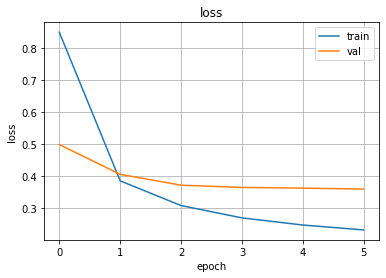

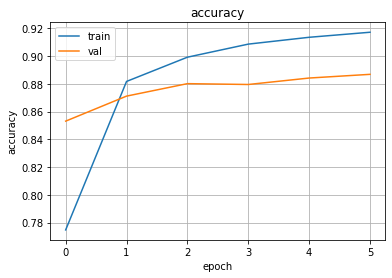

In [129]:
# Train
lstm_dense_training_info = {
    'verbose': 0,
    'epochs' : 6,
    'batch_size' : 64,
    
}

lstm_dense_model = train_model(model=lstm_dense_model,training_info = lstm_dense_training_info)

#### F1-Macro evaluation

In [130]:
loss, accuracy = lstm_dense_model.evaluate(x_val, y_val)
print(f"Model loss: {loss}, accuracy: {accuracy}")

# Inference and evaluate
# The report is going to be used in the conclusions to discuss errors
lstm_dense_score, report = compute_f1(lstm_dense_model, x_val, y_val, get_report=True)
print(f'F1_score on the validation set is: {lstm_dense_score}')

975/975 [==============================] - 3s 3ms/step - loss: 0.3596 - accuracy: 0.8868
Model loss: 0.35959699749946594, accuracy: 0.886797308921814
Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 31183 samples
488/488 [==============================] - 1s 2ms/step
F1_score on the validation set is: 0.716968781623891


## Summary

In [131]:
print(f''' 
F1 Macro scores on the validation set:
    Bi-LSTM + Dense = {base_score}
    Bi-GRU + Dense = {gru_score}
    2x Bi-LSTM + Dense = {LSTMx2_score}
    Bi-LSTM + 2x Dense = {lstm_dense_score}
''')

 
F1 Macro scores on the validation set:
    Bi-LSTM + Dense = 0.7158898975529938
    Bi-GRU + Dense = 0.7014973750824088
    2x Bi-LSTM + Dense = 0.7073631759712223
    Bi-LSTM + 2x Dense = 0.716968781623891



Bi-LSTM + Dense layer and Bi-LSTM + 2xDense layers result to be the bests on the validation set.

F1-Score on the test set 

In [142]:
test_base_score = compute_f1(base_model, x_test, y_test)
test_lstm_dense_score, report_test  = compute_f1(lstm_dense_model, x_test, y_test, get_report=True)

Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 15545 samples
243/243 [==============================] - 1s 2ms/step
Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 15545 samples
243/243 [==============================] - 1s 2ms/step


In [143]:
print(f''' 
F1 Macro scores on the test set:
    Bi-LSTM + Dense = {test_base_score}
    Bi-LSTM + 2x Dense = {test_lstm_dense_score}
''')

 
F1 Macro scores on the test set:
    Bi-LSTM + Dense = 0.7937372408245957
    Bi-LSTM + 2x Dense = 0.7929983470970317



### Error analysis 

Both the models have a better performance on the test set with respect to the validation set. Let's see the scores for each class, focusing on the class distribution in the different sets

In [144]:
val_not_test_labels = [label for label in dfc_val['label'].drop_duplicates().values if label not in dfc_test['label'].drop_duplicates().values ]
test_not_val_labels = [label for label in dfc_test['label'].drop_duplicates().values if label not in dfc_val['label'].drop_duplicates().values ]

print(f"Labels in the validation set that are not in the test set: \n{val_not_test_labels}")
print(f"Labels in the test set that are not in the validation set: \n{test_not_val_labels}")

Labels in the validation set that are not in the test set: 
['FW', 'UH', '#', 'LS']
Labels in the test set that are not in the validation set: 
[]


The validation set is a well representation of the test set, including all of its classes.

There are few labels that are not present in the test set.

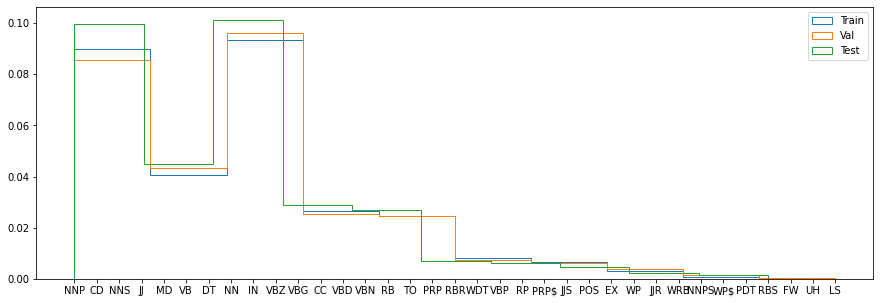

In [145]:
# Class distribution in the sets, normalized.

plt.figure(figsize=(15,5))
plt.hist(dfc_train[~dfc_train["label"].isin(punctuation_classes)].label, 
#plt.hist(dfc_train.label, 
                density=True,
                label="Train",
                histtype="step",
                )
plt.hist(dfc_val[~dfc_val["label"].isin(punctuation_classes)].label, 
#plt.hist(dfc_val.label, 
                density=True,
                label="Val",
                histtype="step",
                )

plt.hist(dfc_test[~dfc_test["label"].isin(punctuation_classes)].label, 
#plt.hist(dfc_test.label, 
                density=True,
                label="Test",
                histtype="step",
                )

plt.legend()
plt.show()

In [146]:
# Get a dataframe from the report of the last model on the validation set
df_report = pd.DataFrame.from_records(report).transpose()

# Add encoded_labels to the report doing a merge, drop not label rows
df_report['encoded_label'] = df_report.index
df_report = df_report[df_report[['encoded_label']].apply(lambda x: x[0].isdigit(), axis=1)]
df_report['encoded_label'] = pd.to_numeric(df_report['encoded_label'])
df_report.reset_index(drop=True, inplace=True)

df_rep_encod = pd.merge(left=df_report, right=df_labels, how="inner", on = "encoded_label")
df_rep_encod.drop(["precision", "recall"], axis=1, inplace=True) 
print(df_rep_encod.head())



   f1-score  support  encoded_label label
0  0.988703   2754.0             10    DT
1  0.944444     34.0             11    EX
2  0.000000      2.0             12    FW
3  0.965840   3275.0             13    IN
4  0.754403   1924.0             14    JJ


<Figure size 1080x144 with 0 Axes>

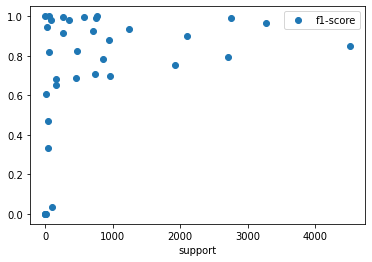

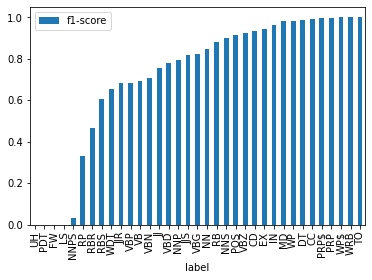

In [147]:
# Plot 
plt.figure(figsize=(15,2))
df_rep_encod.plot(x="support", y="f1-score", style="o")
df_rep_encod.sort_values("f1-score", inplace= True)
df_rep_encod.plot(x="label", y="f1-score", kind="bar", sort_columns=True)
plt.show()

The f1 score is not support related, there are example with few instances with high f1 score, and viceversa.

Without considering the '#' label, not considered in the evaluation, it's possible to see that the classes 'UH', 'FW' and 'LS', which are present in the validation set but not in the test set, are the ones with a null F1-score, decreasing the average.

    f1-score   support  encoded_label label
22  0.000000  0.000000             33    UH
13  0.000000  0.002660             23   PDT
2   0.000000  0.000000             12    FW
7   0.000000  0.000222             17    LS
11  0.033898  0.022833             21  NNPS
The classes not present in the test set but in the validation
word             7
label            7
encoded_label    7
dtype: int64


<Figure size 1080x360 with 0 Axes>

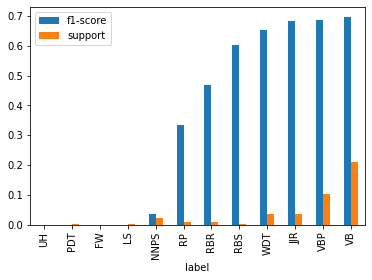

In [148]:
dfc_val_labels = dfc_val[~dfc_val["label"].isin(punctuation_classes)]
plt.figure(figsize=(15,5))

#normalize the support values
df_rep_encod['support'] = (df_rep_encod['support'] - df_rep_encod['support'].min())/(df_rep_encod['support'].max()-df_rep_encod['support'].min()) 
print(df_rep_encod.head())

# Plot the F1 score and the normalized label's count (support) with a threshold
df_rep_encod[df_rep_encod["f1-score"] <= 0.7].plot(x="label", y=["f1-score", "support"], kind="bar")

# Count the classes only present in the validation
count_label_val_notest = dfc_val_test = dfc_val_labels[dfc_val_labels["label"].isin(val_not_test_labels)].count()
print(f"The classes not present in the test set but in the validation\n{count_label_val_notest}")

It is possible to observe that UH (Interjection), LS (List item marker) and FW (Foreign word) labels, cointaned in the validation set but not in the test set have a null f1-score even with a few example (7), decreasing the average of the validation set by a lot.

Let's check the test report to see if there are important variation on the F1-score of each class

In [149]:
# Get a dataframe from the report on test set, obtained from the baseline model
df_report_test = pd.DataFrame.from_records(report_test).transpose()

df_report_test['encoded_label'] = df_report_test.index
df_report_test = df_report_test[df_report_test[['encoded_label']].apply(lambda x: x[0].isdigit(), axis=1)]
df_report_test['encoded_label'] = pd.to_numeric(df_report_test['encoded_label'])
df_report_test.reset_index(drop=True, inplace=True)

df_rep_encod_test = pd.merge(left=df_report_test, right=df_labels, how="inner", on = "encoded_label")
df_rep_encod_test.drop(["precision", "recall"], axis=1, inplace=True) 

print(df_rep_encod_test.head())


   f1-score  support  encoded_label label
0  0.988333   1335.0             10    DT
1  0.909091      5.0             11    EX
2  0.967683   1630.0             13    IN
3  0.712702    918.0             14    JJ
4  0.745098     59.0             15   JJR


In [150]:
#normalize the support values
df_rep_encod_test['support'] = (df_rep_encod_test['support'] - df_rep_encod_test['support'].min())/(df_rep_encod_test['support'].max()-df_rep_encod_test['support'].min()) 

   f1-score val  support val  encoded_label label  f1-score test  support test
0      0.988333     0.559664             10    DT       0.988703      0.610064
1      0.909091     0.000840             11    EX       0.944444      0.007094
2      0.967683     0.683613             13    IN       0.965840      0.725560
3      0.712702     0.384454             14    JJ       0.754403      0.426070
4      0.745098     0.023529             15   JJR       0.685039      0.036134


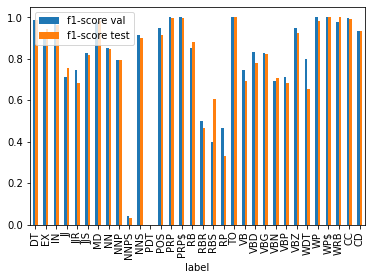

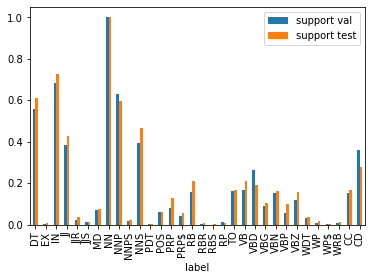

In [151]:
df_full_report = pd.merge(right=df_rep_encod,  
                            left=df_rep_encod_test,
                            suffixes=[" val"," test"],
                            how="inner", 
                            on=["encoded_label","label"])
print(df_full_report.head())
df_full_report.plot(x="label", y=["f1-score val", "f1-score test"], kind="bar")
df_full_report.plot(x="label", y=["support val", "support test"], kind="bar")

F1 score compared between validation and test it's quite similar for every label, except for a few variations.